# In this notebook we fit a SEIR model with hidden states to the Russia Covid-19 data

In [254]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.integrate import odeint
import lmfit
from tqdm.auto import tqdm
from copy import deepcopy
from sklearn.metrics import mean_absolute_error

In [220]:
sns.set()
%matplotlib inline

In [221]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [222]:
%autoreload 2

In [223]:
from sir_models.models import SEIRHidden
from sir_models.fitters import HiddenCurveFitter
from sir_models.utils import stepwise, eval_k_days_ahead

# Load data

In [224]:
DATASET_PATH = '/media/boris/ubuntu_data/datasets/covid-19-data/public/data/owid-covid-data.csv'
df = pd.read_csv(DATASET_PATH)

In [225]:

useless_columns = ['iso_code', 'continent',
       'new_vaccinations_smoothed', 'total_vaccinations_per_hundred',
       'people_vaccinated_per_hundred', 'people_fully_vaccinated_per_hundred',
       'new_vaccinations_smoothed_per_million', 'stringency_index',
       'population_density', 'median_age', 'aged_65_older',
       'aged_70_older', 'gdp_per_capita', 'extreme_poverty',
       'cardiovasc_death_rate', 'diabetes_prevalence', 'female_smokers',
       'male_smokers', 'handwashing_facilities', 'hospital_beds_per_thousand',
       'life_expectancy', 'human_development_index', 'total_cases_per_million', 'new_cases_per_million',
       'new_cases_smoothed_per_million', 'total_deaths_per_million',
       'new_deaths_per_million', 'new_deaths_smoothed_per_million', 'icu_patients_per_million', 'hosp_patients_per_million', 'weekly_icu_admissions_per_million',
        'weekly_hosp_admissions_per_million', 'total_tests_per_thousand',  'new_tests_per_thousand', 'new_tests_smoothed_per_thousand', 'icu_patients', 'hosp_patients',
       'weekly_icu_admissions', 'weekly_hosp_admissions',
                   'total_vaccinations',
       'people_vaccinated', 'people_fully_vaccinated', 'new_vaccinations',
                  ]
df = df.drop(columns=useless_columns)
df.date = pd.to_datetime(df.date)

df = df[df.location == 'Russia']

df = df.fillna(0)
df.head().T

,52406,52407,52408,52409,52410
location,Russia,Russia,Russia,Russia,Russia
date,2020-01-31 00:00:00,2020-02-01 00:00:00,2020-02-02 00:00:00,2020-02-03 00:00:00,2020-02-04 00:00:00
total_cases,2.0,2.0,2.0,2.0,2.0
new_cases,2.0,0.0,0.0,0.0,0.0
new_cases_smoothed,0.0,0.0,0.0,0.0,0.0
total_deaths,0.0,0.0,0.0,0.0,0.0
new_deaths,0.0,0.0,0.0,0.0,0.0
new_deaths_smoothed,0.0,0.0,0.0,0.0,0.0
reproduction_rate,0.0,0.0,0.0,0.0,0.0
new_tests,0.0,0.0,0.0,0.0,0.0


# Define model and fitter

In [226]:
class SEIRHidden_OWID(SEIRHidden):
    def get_fit_params(self, data):
        params = super().get_fit_params(data)
        params['population'].value = df.iloc[0].population
        return params


# Model

In [227]:
train_subset = df[
                #(df.date >= '2020-03-25') & 
                  (df.date <= '2020-11-30')]
train_subset.head()

,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,reproduction_rate,new_tests,total_tests,new_tests_smoothed,positive_rate,tests_per_case,tests_units,population
52406,Russia,2020-01-31,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,145934460.0
52407,Russia,2020-02-01,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,145934460.0
52408,Russia,2020-02-02,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,145934460.0
52409,Russia,2020-02-03,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,145934460.0
52410,Russia,2020-02-04,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,145934460.0


In [228]:
test_subset = df[df.date > train_subset.iloc[-1].date]
test_subset.date[:3]

52711   2020-12-01
52712   2020-12-02
52713   2020-12-03
Name: date, dtype: datetime64[ns]

In [229]:
stepwize_size = 60
model = SEIRHidden_OWID(stepwise_size=stepwize_size)
fitter = HiddenCurveFitter(
     new_deaths_col='new_deaths_smoothed',
     new_cases_col='new_cases_smoothed',
     max_iters=1000,
     save_params_every=10,
#      brute_params=['epidemic_started_days_ago']
)
fitter.fit(model, train_subset)

Reached max iters
Reached max iters



In [232]:
result = fitter.result
result

In [233]:
incubation_days = model.params['incubation_days'].value
infectious_days = model.params['infectious_days'].value
print(f'Incubation period: {incubation_days:.2f}')
print(f'Infectious period: {infectious_days:.2f}')

Incubation period: 3.10
Infectious period: 8.95


In [234]:
train_initial_conditions = model.get_initial_conditions(train_subset)
train_t = np.arange(len(train_subset))

(S, E, I, Iv, R, Rv, D, Dv), history = model.predict(train_t, train_initial_conditions)
(new_exposed,
         new_infected_invisible, new_infected_visible,
         new_recovered_invisible,
         new_recovered_visible,
         new_dead_invisible, new_dead_visible) = model.compute_daily_values(S, E, I, Iv, R, Rv, D, Dv)

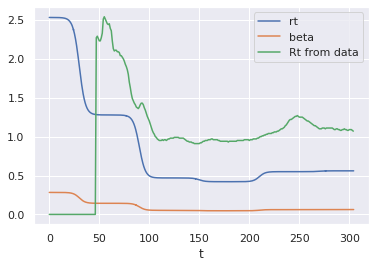

In [235]:
plt.figure()
history.rt.plot()
history.beta.plot()
plt.plot(train_t, train_subset.reproduction_rate, label='Rt from data')
plt.legend()
plt.show()

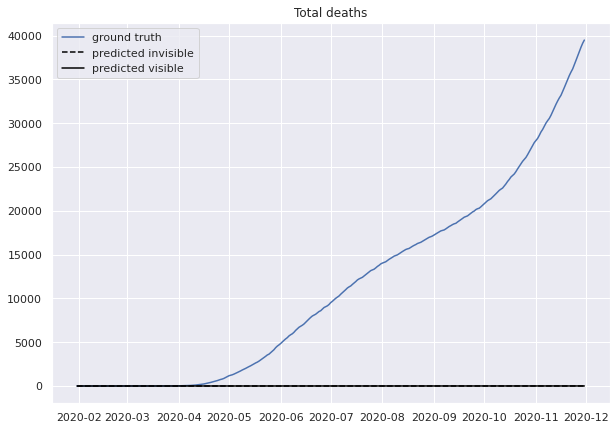

In [236]:
plt.figure(figsize=(10, 7))
plt.plot(train_subset.date, train_subset['total_deaths'], label='ground truth')
plt.plot(train_subset.date, D, label='predicted invisible', color='black', linestyle='dashed' )
plt.plot(train_subset.date, Dv, label='predicted visible', color='black')
plt.legend()
plt.title('Total deaths')
plt.show()

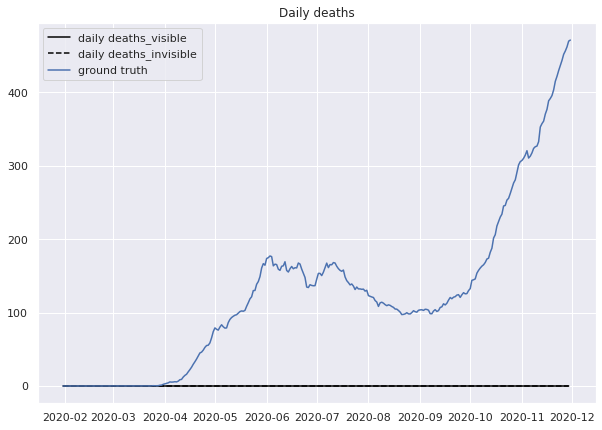

In [237]:
plt.figure(figsize=(10, 7))
plt.plot(train_subset.date[:-1], new_dead_visible, label='daily deaths_visible', color='black')

plt.plot(train_subset.date[:-1], new_dead_invisible, label='daily deaths_invisible', color='black', linestyle='dashed')

plt.plot(train_subset.date, train_subset['new_deaths_smoothed'], label='ground truth')
plt.legend()
plt.title('Daily deaths')
plt.show()

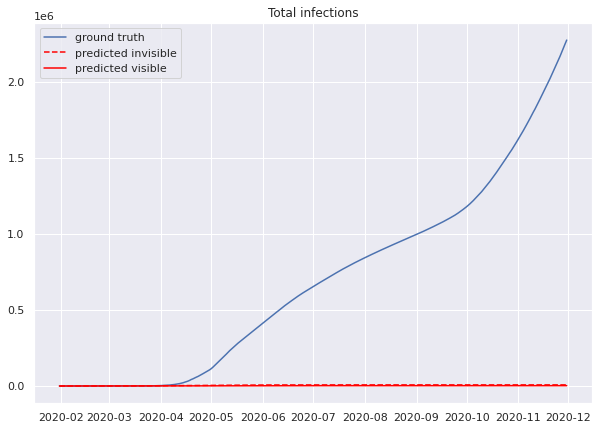

In [238]:
plt.figure(figsize=(10, 7))
plt.plot(train_subset.date, train_subset['total_cases'], label='ground truth')
plt.plot(train_subset.date, I.cumsum(), label='predicted invisible', color='red', linestyle='dashed' )
plt.plot(train_subset.date, Iv.cumsum(), label='predicted visible', color='red')
plt.legend()
plt.title('Total infections')
plt.show()

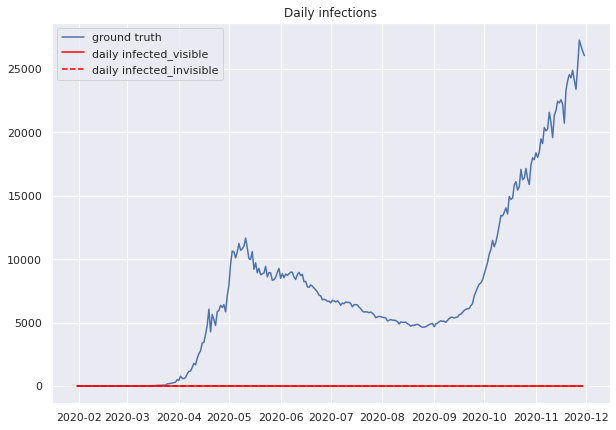

In [239]:
plt.figure(figsize=(10, 7))
plt.plot(train_subset.date, train_subset['new_cases'], label='ground truth')

plt.plot(train_subset.date[:-1], new_infected_visible, label='daily infected_visible', color='red')

plt.plot(train_subset.date[:-1], new_infected_invisible, label='daily infected_invisible', color='red', linestyle='dashed')
plt.legend()
plt.title('Daily infections')
plt.show()

# Obtain forecast

In [240]:
test_t = len(train_subset) + np.arange(len(test_subset))

In [241]:
train_t, test_t

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
        130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
        143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
        169, 170, 171, 172, 173, 174, 175, 176, 177

In [242]:
test_initial_conds = (S[-1], E[-1], I[-1], Iv[-1], R[-1], Rv[-1], D[-1], Dv[-1])

In [243]:
(test_S, test_E, test_I, test_Iv, test_R, test_Rv, test_D, test_Dv), history = model.predict(test_t, test_initial_conds)

In [244]:
(test_new_exposed,
         test_new_infected_invisible, test_new_infected_visible,
         test_new_recovered_invisible,
         test_new_recovered_visible,
         test_new_dead_invisible, test_new_dead_visible) = model.compute_daily_values(test_S, test_E, test_I, test_Iv, test_R, test_Rv, test_D, test_Dv)

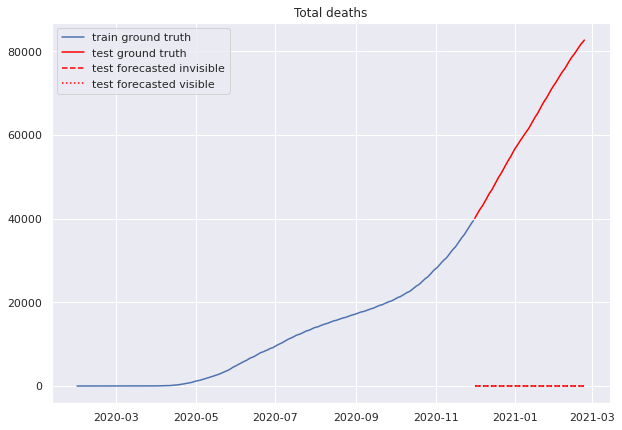

In [245]:
plt.figure(figsize=(10, 7))
plt.plot(train_subset.date, train_subset['total_deaths'], label='train ground truth')
# plt.plot(train_subset.date, D, label='train fit invisible')

plt.plot(test_subset.date, test_subset['total_deaths'], label='test ground truth', color='red')
plt.plot(test_subset.date, test_D, label='test forecasted invisible', color='red', linestyle='dashed')
plt.plot(test_subset.date, test_Dv, label='test forecasted visible', color='red', linestyle=':')
plt.legend()
plt.title('Total deaths')
plt.show()

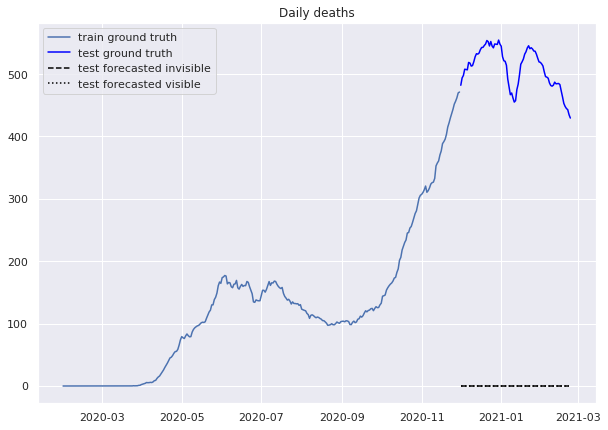

In [246]:
plt.figure(figsize=(10, 7))
# plt.plot(train_subset.date[:-1], new_dead_visible, label='daily deaths_visible', color='black')
# plt.plot(train_subset.date[:-1], new_dead_invisible, label='daily deaths_invisible', color='black', linestyle='dashed')
plt.plot(train_subset.date, train_subset['new_deaths_smoothed'], label='train ground truth')

plt.plot(test_subset.date, test_subset['new_deaths_smoothed'], label='test ground truth', color='blue')
plt.plot(test_subset.date[:-1], test_new_dead_invisible, label='test forecasted invisible', color='black', linestyle='dashed')
plt.plot(test_subset.date[:-1], test_new_dead_visible, label='test forecasted visible', color='black', linestyle=':')
plt.legend()
plt.title('Daily deaths')
plt.show()

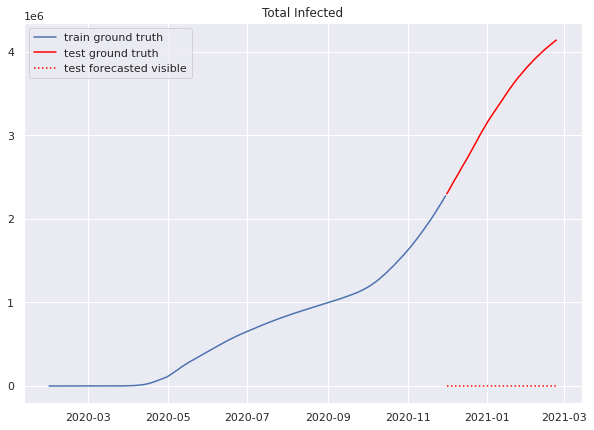

In [247]:
plt.figure(figsize=(10, 7))
plt.plot(train_subset.date, train_subset['total_cases'], label='train ground truth')
# plt.plot(train_subset.date, I.cumsum(), label='train fit')

plt.plot(test_subset.date, test_subset['total_cases'], label='test ground truth', color='red')
# plt.plot(test_subset.date, I.sum()+test_I.cumsum(), label='test forecasted invisible', color='red', linestyle='dashed')
plt.plot(test_subset.date, Iv.sum()+test_Iv.cumsum(), label='test forecasted visible', color='red', linestyle=':')
plt.legend()
plt.title('Total Infected')
plt.show()

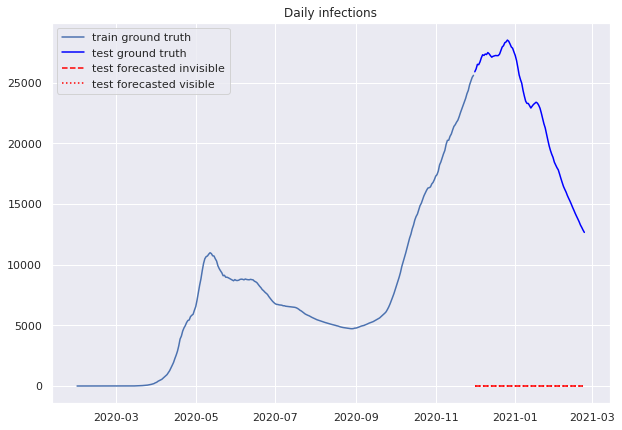

In [248]:
plt.figure(figsize=(10, 7))
plt.plot(train_subset.date, train_subset['new_cases_smoothed'], label='train ground truth')

plt.plot(test_subset.date, test_subset['new_cases_smoothed'], label='test ground truth', color='blue')
plt.plot(test_subset.date[:-1], test_new_infected_invisible, label='test forecasted invisible', color='red', linestyle='dashed')
plt.plot(test_subset.date[:-1], test_new_infected_visible, label='test forecasted visible', color='red', linestyle=':')
plt.legend()
plt.title('Daily infections')
plt.show()

# 7-day ahead evaluate

In [255]:
eval_period_start_t = len(df[df.date < '2020-05-01'])

In [257]:
pred_dates, baseline_pred_D, model_pred_D, true_D, fitters = eval_k_days_ahead(df, 
                  SEIRHidden_OWID, 
                  HiddenCurveFitter, 
                  eval_period_start=eval_period_start_t, 
                  n_eval_points=10, 
                  total_dead_col='total_deaths', 
                  model_kwargs={'stepwise_size': 60}, 
                  fitter_kwargs=dict(verbose=True,
                                     new_deaths_col='new_deaths_smoothed',
                                     new_cases_col='new_cases_smoothed',
                                     max_iters=1000,
                                     save_params_every=250,
                                     #brute_params=['epidemic_started_days_ago']
                                    ), 
                  deaths_index_in_compartments=7,
                  k=30)

Reached max iters
Reached max iters



Reached max iters
Reached max iters



In [258]:
overall_errors_model = [mean_absolute_error(true, pred) for true, pred in zip(true_D, model_pred_D)]
overall_errors_baseline = [mean_absolute_error(true, pred) for true, pred in zip(true_D, baseline_pred_D)]

point_errors_model = [mean_absolute_error(true[-1:], pred[-1:]) for true, pred in zip(true_D, model_pred_D)]
point_errors_baseline = [mean_absolute_error(true[-1:], pred[-1:]) for true, pred in zip(true_D, baseline_pred_D)]

In [259]:
print('Mean overall error baseline', np.mean(overall_errors_baseline))
print('Mean overall error model', np.mean(overall_errors_model))

print('Mean point 7 days ahead error baseline', np.mean(point_errors_baseline))
print('Mean point 7 days ahead error model', np.mean(point_errors_model))

Mean overall error baseline 3943.416666666667
Mean overall error model 51324.130334880436
Mean point 7 days ahead error baseline 7894.625
Mean point 7 days ahead error model 51368.84844961471


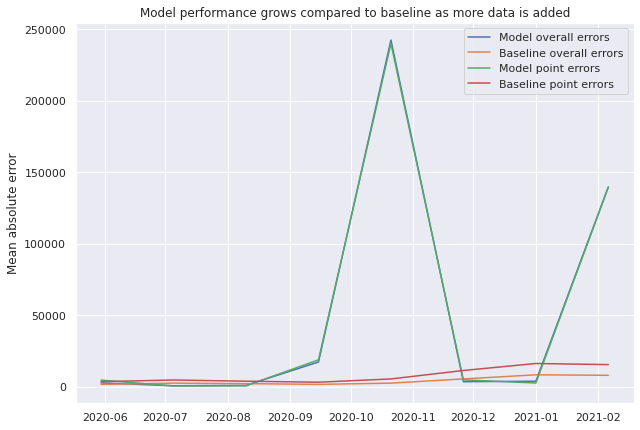

In [260]:
x_dates = [d[-1] for d in pred_dates]

plt.figure(figsize=(10, 7))
plt.plot(x_dates, overall_errors_model, label='Model overall errors')
plt.plot(x_dates, overall_errors_baseline, label='Baseline overall errors')

plt.plot(x_dates, point_errors_model, label='Model point errors')
plt.plot(x_dates, point_errors_baseline, label='Baseline point errors')

plt.legend()
plt.ylabel('Mean absolute error')
plt.title('Model performance grows compared to baseline as more data is added')
plt.show()

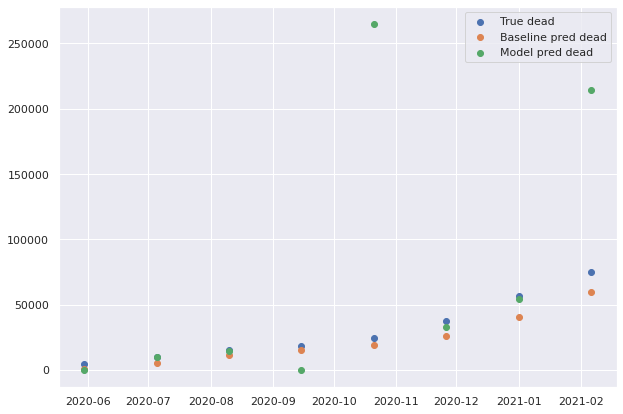

In [261]:
x_dates = [d[-1] for d in pred_dates]

plt.figure(figsize=(10, 7))
plt.scatter(x_dates, [v[-1] for v in true_D], label='True dead')
plt.scatter(x_dates, [v[-1] for v in baseline_pred_D], label='Baseline pred dead')
plt.scatter(x_dates, [v[-1] for v in model_pred_D], label='Model pred dead')

plt.legend()
plt.show()

# Eval 30 days ahead on fixed dates

In [262]:
def eval_k_days_ahead_dates(df, 
                      model_cls,
                      fitter_cls,
                      eval_dates,
                      total_dead_col='total_deaths',
                      model_kwargs=None,
                      fitter_kwargs=None,
                      deaths_index_in_compartments=4,
                      k=7):
    model_kwargs = model_kwargs or {}
    fitter_kwargs = fitter_kwargs or {'verbose': False}

    pred_dates = []
    true_D = []
    baseline_pred_D = []
    model_pred_D = []
    fitters = []

    progress_bar = tqdm(eval_dates, total=len(eval_dates))
    for date in progress_bar:
        t = len(df[df.date < date])
        train_df = df.iloc[:t]

        model = model_cls(**model_kwargs)
        fitter = fitter_cls(**fitter_kwargs)
        fitter.fit(model, train_df)

        train_initial_conditions = model.get_initial_conditions(train_df)
        train_t = np.arange(len(train_df))
        state, history = model.predict(train_t, train_initial_conditions)

        test_initial_conds = [compartment[-1] for compartment in state]
        eval_t = np.arange(train_t[-1]+1, t+k, 1)

        state, history = model.predict(eval_t, test_initial_conds)

        D = state[deaths_index_in_compartments]

        pred_dates.append(df.date.iloc[t:t+k].values)
        model_pred_D.append(D)
        baseline_pred_D.append([train_df.iloc[-1][total_dead_col]] * k)
        true_D.append(df[total_dead_col].iloc[eval_t].values)
        fitters.append(fitter)

    return pred_dates, baseline_pred_D, model_pred_D, true_D, fitters


In [263]:
# Regions where Rt does not jump much
eval_dates1 = pd.date_range(start='2020-06-01', end='2020-09-01')[::5]
eval_dates2 = pd.date_range(start='2020-11-01', end='2020-12-15')[::5]
eval_dates = pd.concat([pd.Series(eval_dates1), pd.Series(eval_dates2)]).values
eval_dates[:10], len(eval_dates)

(array(['2020-06-01T00:00:00.000000000', '2020-06-06T00:00:00.000000000',
        '2020-06-11T00:00:00.000000000', '2020-06-16T00:00:00.000000000',
        '2020-06-21T00:00:00.000000000', '2020-06-26T00:00:00.000000000',
        '2020-07-01T00:00:00.000000000', '2020-07-06T00:00:00.000000000',
        '2020-07-11T00:00:00.000000000', '2020-07-16T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 28)

In [264]:
pred_dates, baseline_pred_D, model_pred_D, true_D, fitters = eval_k_days_ahead_dates(df, 
                  SEIRHidden_OWID, 
                  HiddenCurveFitter, 
                  eval_dates=eval_dates, 
                  total_dead_col='total_deaths', 
                  model_kwargs={'stepwise_size': 60}, 
                  fitter_kwargs=dict(verbose=True,
                                     new_deaths_col='new_deaths_smoothed',
                                     new_cases_col='new_cases_smoothed',
                                     max_iters=1000,
                                     save_params_every=250,
                                     #brute_params=['epidemic_started_days_ago']
                                    ), 
                  deaths_index_in_compartments=7,
                  k=30)

Reached max iters
Reached max iters



In [269]:
overall_errors_model = [mean_absolute_error(true, pred) for true, pred in zip(true_D, model_pred_D)]
overall_errors_baseline = [mean_absolute_error(true, pred) for true, pred in zip(true_D, baseline_pred_D)]

point_errors_model = [mean_absolute_error(true[-1:], pred[-1:]) for true, pred in zip(true_D, model_pred_D)]
point_errors_baseline = [mean_absolute_error(true[-1:], pred[-1:]) for true, pred in zip(true_D, baseline_pred_D)]

In [270]:
print('Mean overall error baseline', np.mean(overall_errors_baseline))
print('Mean overall error model', np.mean(overall_errors_model))

print('Mean point 7 days ahead error baseline', np.mean(point_errors_baseline))
print('Mean point 7 days ahead error model', np.mean(point_errors_model))

Mean overall error baseline 3730.3821428571423
Mean overall error model 28544.015704259516
Mean point 7 days ahead error baseline 7317.785714285715
Mean point 7 days ahead error model 28246.553100162662


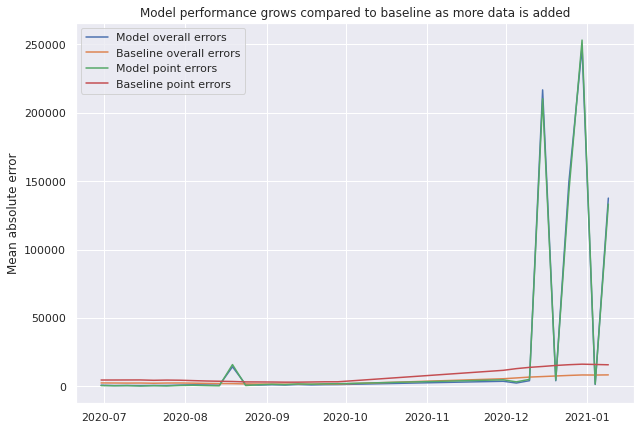

In [271]:
x_dates = [d[-1] for d in pred_dates]

plt.figure(figsize=(10, 7))
plt.plot(x_dates, overall_errors_model, label='Model overall errors')
plt.plot(x_dates, overall_errors_baseline, label='Baseline overall errors')

plt.plot(x_dates, point_errors_model, label='Model point errors')
plt.plot(x_dates, point_errors_baseline, label='Baseline point errors')

plt.legend()
plt.ylabel('Mean absolute error')
plt.title('Model performance grows compared to baseline as more data is added')
plt.show()

In [278]:
print('Mean overall error baseline', np.mean(overall_errors_baseline[:19]))
print('Mean overall error model', np.mean(overall_errors_model[:19]))

print('Mean point 7 days ahead error baseline', np.mean(point_errors_baseline[:19]))
print('Mean point 7 days ahead error model', np.mean(point_errors_model[:19]))

Mean overall error baseline 2019.5140350877195
Mean overall error model 1661.116595046644
Mean point 7 days ahead error baseline 3834.315789473684
Mean point 7 days ahead error model 1697.2977520324328


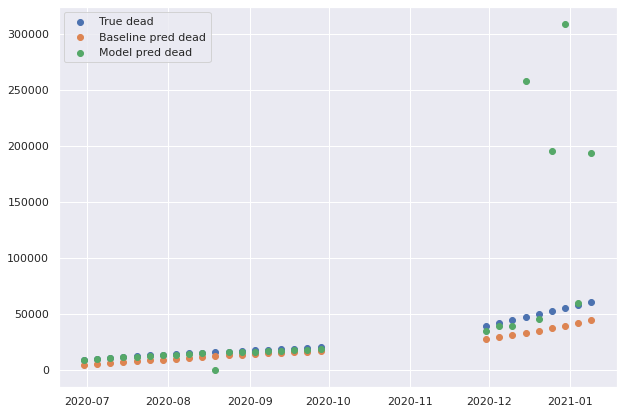

In [272]:
x_dates = [d[-1] for d in pred_dates]

plt.figure(figsize=(10, 7))
plt.scatter(x_dates, [v[-1] for v in true_D], label='True dead')
plt.scatter(x_dates, [v[-1] for v in baseline_pred_D], label='Baseline pred dead')
plt.scatter(x_dates, [v[-1] for v in model_pred_D], label='Model pred dead')

plt.legend()
plt.show()